# Part of Speech Tagger (FeedForward & RNN comparison)
In this notebook we train two Neural Networks for Part of Speech (POS) task. First we use unsupervised pretrained  word
embeddings (vector representation of words) of GloVe-WiKi 50D and UD_English-GUM Dataset contained train, validation & test
examples of sentences and POS tag per word. Second we preprocess the dataset using word embeddings using two types of
preprocessing objects, the first for Slided Window FeedForward model and the second for RNN model.

After the preprocessing, we train models using early stopping & normalized gradient clipping methods. We give examples of
POS tagging on sentences.

For visualizing the results we plot Cost (Categorical Cross Entropy) & Score (F1 score) curves per
epoch and Recall/Precision curve printing the Area Under the Curve (AUC).

## Additional Packages & Dataset downloading

In [1]:
!pip install conllu
!pip install tensorflow_datasets
!pip install tensorflow_addons
!pip install gensim

In [2]:
!wget https://github.com/UniversalDependencies/UD_English-GUM/archive/master.zip
!unzip master.zip

In [3]:
from algomorphism.base import LossBase, BaseNeuralNetwork, MetricBase
from algomorphism.figures.nn import multiple_models_history_figure
from algomorphism.losses import ClassWeightedCategoricalCrossEntropy as ClassWeightedCategoricalCrossEntropyLoss
from algomorphism.metrics import ClassWeightedCategoricalCrossEntropy as ClassWeightedCategoricalCrossEntropyMetric

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, Dropout, PReLU, BatchNormalization, Input
from tensorflow.keras.layers import Embedding, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

from conllu import parse_incr
import gensim.downloader as api
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [4]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-26 09:42:07.589399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 09:42:07.598746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 09:42:07.599370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Preprocessing


### Load GloVe word embeddings model

In [5]:
word2vec_model = api.load('glove-wiki-gigaword-50')


### Dataset objects for preprocessing and getting dataset examples

In [6]:
class PosFfDataset(object):
  """
  POS Dataset object for FeedForward model
  """
  def __init__(self, word2vec_model, window=1):
    self.word2vec_model = word2vec_model
    self.__w = window

  def set_data_from_files(self, train_path, val_path, test_path):
    file_trn = open(train_path)
    self.__x_train, tags_train, self.__vocab = self.__window_word2vec_and_tags_training(file_trn)

    file_val = open(val_path)
    self.__x_val, tags_val = self.__window_word2vec_and_tags_val_test(file_val)

    file_test = open(test_path)
    self.__x_test, tags_test = self.__window_word2vec_and_tags_val_test(file_test)


    self.__lb = LabelBinarizer()
    tag_classes = list(set(tags_train))
    self.__lb.fit(tag_classes)

    self.__y_train = self.__lb.transform(tags_train)
    self.__y_val = self.__lb.transform(tags_val)
    self.__y_test = self.__lb.transform(tags_test)

    self.train = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_train, tf.float32),
        tf.cast(self.__y_train, tf.int64)
    )).batch(128)

    self.val = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_val, tf.float32),
        tf.cast(self.__y_val, tf.int64)
    )).batch(128)

    self.test = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_test, tf.float32),
        tf.cast(self.__y_test, tf.int64)
    )).batch(128)

  def __plus_operator_sliding_window(self, words2vecs):
    if self.__w == 1:
      return words2vecs

    words2vecs = np.array(words2vecs)
    N = words2vecs.shape[0]
    words2vecs = np.concatenate((np.zeros(((self.__w-1)//2, words2vecs.shape[1])),
                                words2vecs,
                                np.zeros(((self.__w-1)//2, words2vecs.shape[1]))
                                ),axis=0)
    sent_embedings = []
    for i in range(0, N):
      sent_embedings.append(
          words2vecs[i:i+self.__w].sum(axis=0)
      )
    return sent_embedings

  # this is useful for preprocess train, val, test data
  def __window_word2vec_and_tags_training(self, file):
    window_embedings = []
    tags = []
    vocab = set()
    for sent in parse_incr(file):
      words2vecs = []
      for word in sent:
        try:
          words2vecs.append(self.word2vec_model[word['form']])
          tags.append(word['upostag'])
          vocab.add(word['form'])
        except Exception as e:
          pass

      if len(words2vecs) != 0:
        window_embedings+= self.__plus_operator_sliding_window(words2vecs)

    window_embedings = np.array(window_embedings)
    return window_embedings, tags, vocab

  def __window_word2vec_and_tags_val_test(self, file):
    window_embedings = []
    tags = []
    for sent in parse_incr(file):
      words2vecs = []
      for word in sent:
        try:
          if word['form'] in self.__vocab:
            words2vecs.append(self.word2vec_model[word['form']])
          else:
            var = self.word2vec_model[word['form']]
            words2vecs.append(np.zeros(self.word2vec_model.vector_size,))
          tags.append(word['upostag'])
        except Exception as e:
          pass

      if len(words2vecs) != 0:
        window_embedings+= self.__plus_operator_sliding_window(words2vecs)

    window_embedings = np.array(window_embedings)
    return window_embedings, tags

  def window_word2vec_sentece(self,sentence):
    words2vecs = []
    listtag = []
    for word in sentence.split():
      try:
        if word in self.__vocab:
          words2vecs.append(self.word2vec_model[word])
        else:
          words2vecs.append(np.zeros(self.word2vec_model.vector_size,))
        listtag.append([word, ''])
      except Exception as e:
        listtag.append([word, None])

    if len(words2vecs) != 0:
      sent_embedings = self.__plus_operator_sliding_window(words2vecs)
    else:
      return None, listtag

    sent_embedings = np.array(sent_embedings)
    return sent_embedings, listtag

  def get_numpy_dataset(self):
    return self.__x_train, self.__y_train, self.__x_val, self.__y_val, self.__x_test, self.__y_test

  def get_numpy2tag(self, y_, onehot=False):
    if onehot:
      y_ = np.array(y_).argmax(axis=1)
    return self.__lb.classes_[y_]

  def get_tags_names(self):
    return self.__lb.classes_

In [7]:
class PosRnnDataset(object):
  """
  POS Dataset object for RNN model
  """
  def __init__(self, word2vec_model):
    self.word2vec_model = word2vec_model

  def get_numpy_dataset(self):
    return self.__x_train, self.__y_train, self.__x_val, self.__y_val, self.__x_test, self.__y_test

  def __pad_sequence(self, sequence_sent, sequence_tag):
    x = pad_sequences(sequence_sent, maxlen=self.__max_length_sent, padding='post', value=self.sents_encode(['__PAD__'])[0][0])
    sequence_tag = pad_sequences(sequence_tag, maxlen=self.__max_length_sent, padding='post', value=self.tags_encode(['__PAD__'])[0][0])
    y = np.array([self.__lb.transform([int(tag) for tag in list(sequence)]) for sequence in list(sequence_tag)])
    return x, y

  def tag_decode(self, seqquence_tag):
    tag_dec = []
    for seq in seqquence_tag:
      tag_dec.append(self.__tags_encoder.decode(seq))
    return tag_dec

  def sent_decode(self, sequence_sent):
    sents_dec = self.__text_encoder.sequences_to_texts(sequence_sent)
    return sents_dec

  def tags_encode(self, tags):
    tag_enc = []
    for tag in tags:
      tag_enc.append(self.__tags_encoder.encode(tag))
    return tag_enc

  def sents_encode(self, sents):
    sents_enc = self.__text_encoder.texts_to_sequences(sents)
    return sents_enc

  def __set_up_data_from_train_file(self, file_path):
    vocab = set()
    sents = []
    tags = []
    tags_set = set()
    file_obj = open(file_path)
    max_length_sent = 0
    for sent in parse_incr(file_obj):
      tags.append('')
      sents.append('')
      if len(sent) > max_length_sent:
        max_length_sent = len(sent)
      for w in sent:
        try:
          # check if word exist on word emb
          word = str.lower(w['form'])
          var = self.word2vec_model[word]
          sents[-1]+= ' '+str(word)
          vocab.add(str(word))
        except Exception as e:
          # remove the word that doesnt contain in word2vec_model
          sents[-1] += ' '+'__OOV__'
          vocab.add('__OOV__')

        tags[-1] +=  ' '+w['upostag']
        tags_set.add(w['upostag'])


    self.__max_length_sent = max_length_sent
    tags_set.add('__PAD__')
    vocab.add('__PAD__')

    self.__vocab_size = len(vocab)+1
    self.__tags_size = len(tags_set)

    # we experimented with two tf Tokenizers(encoders or more simply coders) tf.keras and tfds Tokenizer(for big corpus)
    self.__text_encoder = tf.keras.preprocessing.text.Tokenizer(self.__vocab_size, oov_token='__UNK__', filters='', lower=False)
    self.__text_encoder.fit_on_texts([' '.join(list(vocab))])
    self.__tags_encoder = tfds.deprecated.text.TokenTextEncoder(
      list(tags_set),
      tokenizer=tfds.deprecated.text.Tokenizer(
        alphanum_only=True
      )
    )

    embedding_dim = self.word2vec_model.vector_size
    embedding_matrix = np.zeros((self.__vocab_size, embedding_dim))
    for word in vocab:
      index = self.sents_encode([word])[0][0]
      try:
        embedding_matrix[index] = self.word2vec_model[word]
      except:
        pass

    self.__embedding_matrix = embedding_matrix
    self.__lb = LabelBinarizer()

    tags_code = [int(tag) for tag in self.__tags_encoder.encode(' '.join(list(tags_set)))]
    self.__lb.fit(tags_code)
    sequence_sent = self.sents_encode(sents)


    sequence_tag = self.tags_encode(tags)
    x_train, y_train = self.__pad_sequence(sequence_sent, sequence_tag)
    return x_train, y_train


  def __set_up_data_from_val_or_test_file(self, file_path):
    sents = []
    tags = []
    file_obj = open(file_path)
    for sent in parse_incr(file_obj):
      tags.append('')
      sents.append('')
      for w in sent:
        try:
          word = str.lower(w['form'])
          var = self.word2vec_model[word]
          sents[-1]+= ' '+word
        except Exception as e:
          # remove the word that doesnt contain in word2vec_model
          sents[-1] += ' '+'__OOV__'
        tags[-1] +=  ' '+w['upostag']

    sequence_sent = self.sents_encode(sents)
    sequence_tag = self.tags_encode(tags)
    x, y = self.__pad_sequence(sequence_sent, sequence_tag)
    return x, y

  def set_data_from_files(self,train_path, val_path, test_path):

    self.__x_train, self.__y_train = self.__set_up_data_from_train_file(train_path)

    self.train = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_train, tf.int32),
        tf.cast(self.__y_train, tf.float32)
    )).batch(128)

    self.__x_val, self.__y_val = self.__set_up_data_from_val_or_test_file(val_path)
    self.__x_test, self.__y_test = self.__set_up_data_from_val_or_test_file(test_path)

    self.val = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_val, tf.int32),
        tf.cast(self.__y_val, tf.float32)
    )).batch(128)

    self.test = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_test, tf.int32),
        tf.cast(self.__y_test, tf.float32)
    )).batch(128)

  def get_max_length_sent(self):
    return self.__max_length_sent

  def get_vocab_size(self):
    return self.__vocab_size

  def get_tags_size(self):
    return self.__tags_size

  def get_embedding_matrix(self):
    return self.__embedding_matrix

## Neural Network Models

### FeedForward

In [8]:
class FeedForward(tf.keras.Model, BaseNeuralNetwork):
  def __init__(self, dataset, x_dim, n_class, learning_rate=1e-4, clip_norm=0.0, early_stop_vars=None):
    tf.keras.Model.__init__(self, name='ff')
    status = [
      [0],
      [1, 2]
    ]

    self.score_mtr = MetricBase(self,
                                [tfa.metrics.F1Score(n_class, average='micro')],
                                status,
                                [0]
                              )

    self.cost_mtr = MetricBase(self,
                                [tf.keras.metrics.CategoricalCrossentropy()],
                                status,
                                [0],
                                1
                              )

    self.cost_loss = LossBase(self,
                              [tf.keras.losses.CategoricalCrossentropy()],
                              status,
                              [0]
                            )

    BaseNeuralNetwork.__init__(self, status, dataset=dataset, learning_rate=learning_rate,
                               clip_norm=clip_norm, early_stop_vars=early_stop_vars)

    self.n_class = n_class
    self.x_dim = x_dim

    self.Input = Input(self.x_dim)

    self.dense1 = Dense(128, name='dense1')
    self.batchnorm1 = BatchNormalization(name='batchnorm1')
    self.prelu1 =  PReLU(name='prelu1')
    self.drop1 = Dropout(0.25, name='drop1')

    self.dense2 = Dense(256, name='dense2')
    self.batchnorm2 = BatchNormalization(name='batchnorm2')
    self.prelu2 =  PReLU(name='prelu2')
    self.drop2 = Dropout(0.3, name='drop2')

    self.dense3 = Dense(512, name='dense3')
    self.batchnorm3 = BatchNormalization(name='batchnorm3')
    self.prelu3 =  PReLU(name='prelu3')
    self.drop3 = Dropout(0.35, name='drop3')

    self.softmax = Dense(self.n_class, activation="softmax",name='softmax')

  def call(self, inputs):

    x = self.dense1(inputs[0])
    x = self.batchnorm1(x)
    x = self.prelu1(x)
    x = self.drop1(x)

    x = self.dense2(x)
    x = self.batchnorm2(x)
    x = self.prelu2(x)
    x = self.drop2(x)

    x = self.dense3(x)
    x = self.batchnorm3(x)
    x = self.prelu3(x)
    x = self.drop3(x)

    y = self.softmax(x)

    return tuple((y,))

### RNN
The data is unbalance, so we use Class Weighted Categorical Cross Entropy cost and F1 score.

In [9]:
class RNN(tf.keras.Model, BaseNeuralNetwork):

  def __init__(self, max_length_sent, vocab_size, n_class, embedding_matrix, dataset, class_weights, learning_rate=1e-4,
               clip_norm=0.0, early_stop_vars=None):

    tf.keras.Model.__init__(self, name='rnn')
    status = [
          [0],
          [1, 2]
        ]

    self.score_mtr = MetricBase(self,
                                [tfa.metrics.F1Score(n_class, average='micro')],
                                status,
                                [0]
                              )

    self.cost_mtr = MetricBase(self,
                               [ClassWeightedCategoricalCrossEntropyMetric(class_weights)],
                               status,
                               [0],
                               1
                              )

    self.cost_loss = LossBase(self,
                              [ClassWeightedCategoricalCrossEntropyLoss(class_weights)],
                              status,
                              [0]
                            )

    BaseNeuralNetwork.__init__(self, status, dataset=dataset,
                           learning_rate=learning_rate,
                           clip_norm=clip_norm,
                           early_stop_vars=early_stop_vars)

    self.Input = Input((max_length_sent,))
    self.embedding = Embedding(vocab_size, embedding_matrix.shape[1],
      mask_zero=True, trainable=True, weights=[embedding_matrix])

    self.lstm = LSTM(512, return_sequences=True, name='lstm', activation='tanh')
    self.bidirectional = Bidirectional(self.lstm, name='bidirectional')
    self.timedistributed = TimeDistributed(Dense(n_class, 'softmax'))

  def call(self, inputs):
    x = self.embedding(inputs[0])
    x = self.bidirectional(x)
    y = self.timedistributed(x)

    return tuple((y,))

## Load Examples

In [ ]:
pos_ff = PosFfDataset(word2vec_model, 3)
pos_rnn = PosRnnDataset(word2vec_model)

train_path = 'UD_English-GUM-master/en_gum-ud-train.conllu'
test_path = 'UD_English-GUM-master/en_gum-ud-test.conllu'
val_path = 'UD_English-GUM-master/en_gum-ud-dev.conllu'

pos_ff.set_data_from_files(train_path, val_path, test_path)
pos_rnn.set_data_from_files(train_path, val_path, test_path)

## Early stopping vars and class weights computation
We use patience early stopping method, that means we track val score and if it doesn't change for specific epochs
(in our case 10) the training process stops. Also, we compute the class weights for rnn model.

In [11]:
early_stop_vars = {
  'es_strategy':'patience',
  'es_metric':'val_score',
  'es_min_delta': 1e-3,
  'es_patience': 10
}

y_train_rnn = pos_rnn.get_numpy_dataset()[1]
y_train_rnn = y_train_rnn.reshape(y_train_rnn.shape[0]*y_train_rnn.shape[1], y_train_rnn.shape[2]).astype(np.float)
class_weights = tf.reduce_mean(y_train_rnn, axis=0)
class_weights = 1 - tf.cast(class_weights, tf.float32)

2021-10-26 09:42:52.918649: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 85231872 exceeds 10% of free system memory.


## Initialize and train nn models

In [12]:
ff = FeedForward(dataset=pos_ff,
                 x_dim=pos_ff.get_numpy_dataset()[0].shape[1:],
                 n_class=len(pos_ff.get_tags_names()),
                 learning_rate=1e-2,
                 clip_norm=0.1,
                 early_stop_vars=early_stop_vars)

In [13]:
ff.train(pos_ff, 50, print_types=['train', 'val'])

Epoch 1 finished
train cost: 1.7211272716522217
train score: 0.38910868763923645
val cost: 1.803920865058899
val score: 0.3563788831233978
Epoch 2 finished
train cost: 1.6171690225601196
train score: 0.41804826259613037
val cost: 1.7150495052337646
val score: 0.3810555636882782
Epoch 3 finished
train cost: 1.5539666414260864
train score: 0.4336835741996765
val cost: 1.6663367748260498
val score: 0.3996504843235016
Epoch 4 finished
train cost: 1.51417076587677
train score: 0.4424848258495331
val cost: 1.634926438331604
val score: 0.4048234820365906
Epoch 5 finished
train cost: 1.4873731136322021
train score: 0.44819313287734985
val cost: 1.6250123977661133
val score: 0.4082489013671875
Epoch 6 finished
train cost: 1.4506456851959229
train score: 0.46145185828208923
val cost: 1.6032854318618774
val score: 0.41726669669151306
Epoch 7 finished
train cost: 1.4122003316879272
train score: 0.47477883100509644
val cost: 1.596621036529541
val score: 0.41691717505455017
Epoch 8 finished
train co

In [14]:
rnn = RNN(pos_rnn.get_max_length_sent(),
          pos_rnn.get_vocab_size(),
          pos_rnn.get_tags_size(),
          pos_rnn.get_embedding_matrix(),
          dataset=pos_rnn,
          class_weights=class_weights,
          learning_rate=1e-1,
          clip_norm=0.1,
          early_stop_vars=early_stop_vars)

In [15]:
rnn.train(pos_rnn, 50, print_types=['train', 'val'])

2021-10-26 10:13:34.820902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Epoch 1 finished
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
train cost: 0.42772895097732544
train score: 0.8707289099693298
val cost: 0.4530748128890991
val score: 0.8625519871711731
Epoch 2 finished
train cost: 0.32033610343933105
train score: 0.9029008150100708
val cost: 0.3465965688228607
val score: 0.891656756401062
Epoch 3 finished
train cost: 0.24970069527626038
train score: 0.920144259929657
val cost: 0.27267464995384216
val score: 0.9123740196228027
Epoch 4 finished
train cost: 0.19

## POS Tagging examples

In [16]:
def ff_tagger(sentence, ff_model, pos_ff_dataset_obj:PosFfDataset):
    window_embedings, listtag = pos_ff_dataset_obj.window_word2vec_sentece(sentence)
    pr = ff_model([window_embedings])[0]
    pr = pos_ff_dataset_obj.get_numpy2tag(pr,onehot=True)
    not_none_cnt = 0
    for i in range(len(listtag)):
      if listtag[i][1] != None:
        print((listtag[i][0], pr[not_none_cnt]))
        not_none_cnt += 1
    print()

def rnn_tagger(sentence, rnn_model, pos_rnn_dataset_obj):
  encode = pos_rnn_dataset_obj.sents_encode([sentence])
  encode = tf.cast(encode, tf.int32)
  pr = rnn_model.call([encode])[0].numpy().argmax(axis=-1) + 1
  pr = pos_rnn_dataset_obj.tag_decode(pr)
  for x, y in zip(sentence.split(), pr[0].split()):
    print((x, y))
  print()

In [17]:
print('FeedForward POS Tagger \n{}'.format('='*22))

ff_tagger('we create a pos tagger and we are very happy for that !', ff, pos_ff)
ff_tagger('hello there ! !', ff, pos_ff)
ff_tagger('how are you ?', ff, pos_ff)
ff_tagger('aesthetic appreciation and spanish art :', ff, pos_ff)

print('RNN POS Tagger \n{}'.format('='*14))

rnn_tagger('we create a pos tagger and we are very happy for that !', rnn, pos_rnn)
rnn_tagger('hello there ! !', rnn, pos_rnn)
rnn_tagger('how are you ?', rnn, pos_rnn)
rnn_tagger('aesthetic appreciation and spanish art :', rnn, pos_rnn)

FeedForward POS Tagger 
('we', 'VERB')
('create', 'VERB')
('a', 'DET')
('pos', 'DET')
('tagger', 'NOUN')
('and', 'PUNCT')
('we', 'PRON')
('are', 'AUX')
('very', 'ADV')
('happy', 'ADV')
('for', 'VERB')
('that', 'PRON')
('!', 'PUNCT')

('hello', 'PUNCT')
('there', 'PUNCT')
('!', 'PUNCT')
('!', 'PUNCT')

('how', 'PRON')
('are', 'PRON')
('you', 'PRON')
('?', 'PUNCT')

('aesthetic', 'ADJ')
('appreciation', 'ADJ')
('and', 'PUNCT')
('spanish', 'PUNCT')
('art', 'NOUN')
(':', 'NOUN')

RNN POS Tagger 
('we', 'PRON')
('create', 'VERB')
('a', 'DET')
('pos', 'NOUN')
('tagger', 'NOUN')
('and', 'CCONJ')
('we', 'PRON')
('are', 'AUX')
('very', 'ADV')
('happy', 'ADJ')
('for', 'ADP')
('that', 'PRON')
('!', 'PUNCT')

('hello', 'INTJ')
('there', 'PRON')
('!', 'PUNCT')
('!', 'PUNCT')

('how', 'PRON')
('are', 'AUX')
('you', 'PRON')
('?', 'PUNCT')

('aesthetic', 'ADJ')
('appreciation', 'NOUN')
('and', 'CCONJ')
('spanish', 'ADJ')
('art', 'NOUN')
(':', 'PUNCT')



## Results Visualization

Create precision recall curve object

In [18]:
class PrecisionRecallCurve(tf.keras.metrics.Metric):
  def __init__(self,thresholds=None):
    super(PrecisionRecallCurve, self).__init__(name='prc')
    self.__precision = tf.keras.metrics.Precision(thresholds=thresholds)
    self.__recall = tf.keras.metrics.Recall(thresholds=thresholds)

  def update_state(self, y_true, y_pred):
    self.__precision.update_state(y_true, y_pred)
    self.__recall.update_state(y_true, y_pred)

  def result(self):
    precision = self.__precision.result().numpy()
    recall = self.__recall.result().numpy()

    precision = self.__fix_precision(precision)
    auc = np.sum((precision[1:] - precision[:-1])*recall[:-1])
    return auc

  def get_precision(self):
    precision = self.__precision.result().numpy()
    precision = self.__fix_precision(precision)
    return precision

  def get_recall(self):
    return self.__recall.result().numpy()

  def reset_states(self):
    self.__precision.reset_state()
    self.__recall.reset_state()

  def __fix_precision(self, precision):
    argmax_precision = precision.argmax()
    precision[argmax_precision:] = 1.0
    return precision

Plot history (Cost & Score per epoch) by nn models.

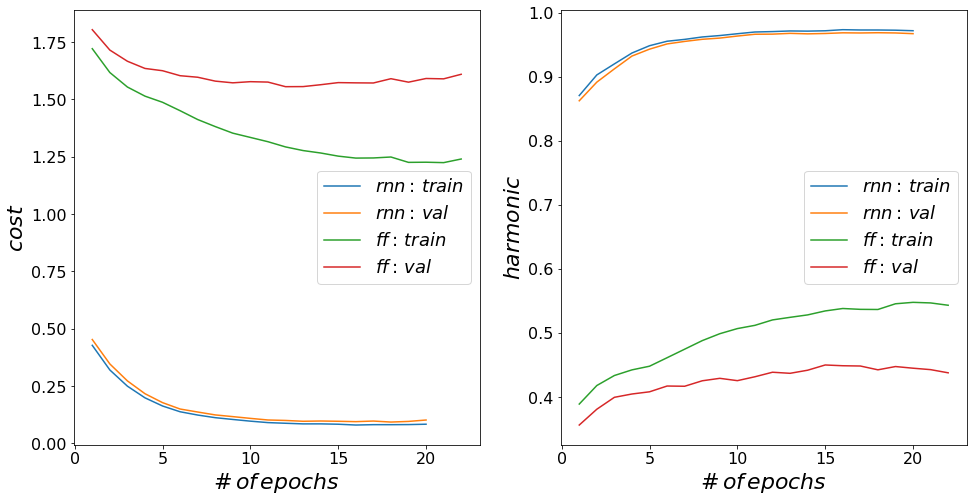

In [19]:
multiple_models_history_figure([rnn, ff])

Plot precision recall curve and print AUC by nn models.

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Text(0.5, 1.0, 'Test auc per model')

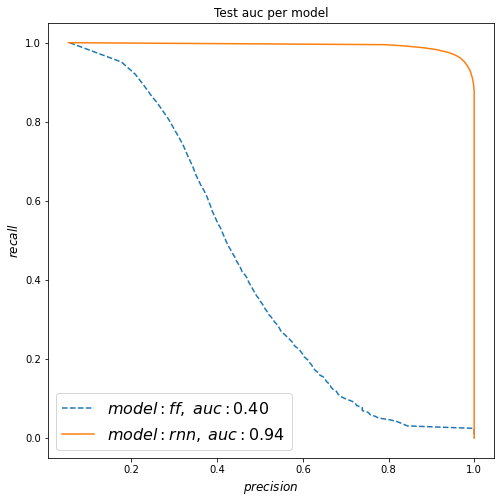

In [20]:
plt.figure(figsize=(8,8))
label_base = r'$model:{}, \; auc:{:.2f}$'
prc = PrecisionRecallCurve(np.linspace(0,1,100).tolist())

for x, y_true in pos_ff.test:
  y_pred = ff([x])[0]
  prc.update_state(y_true, y_pred)
auc = prc.result()
precision = prc.get_precision()
recall = prc.get_recall()
plt.plot(precision, recall,'--', label=label_base.format(ff.name, auc))

prc.reset_states()

for x, y_true in pos_rnn.test:
  y_pred = rnn([x])[0]
  prc.update_state(y_true, y_pred)
auc = prc.result()
precision = prc.get_precision()
recall = prc.get_recall()
plt.plot(precision, recall, label=label_base.format(rnn.name, auc))

plt.legend(fontsize=16, loc='lower left')
plt.xlabel(r"$precision$", fontsize=12)
plt.ylabel(r"$recall$", fontsize=12)
plt.title("Test auc per model")

## References
- UD_English-GUM Dataset: [https://github.com/UniversalDependencies/UD_English-GUM](https://github.com/UniversalDependencies/UD_English-GUM)
- GloVe: [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
- Slided Window POS Tagger: [https://www.dlsi.ua.es/~mlf/docum/sanchezvillamil04p.pdf](https://www.dlsi.ua.es/~mlf/docum/sanchezvillamil04p.pdf)
